In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt


In [2]:


def append_angle_data(eye_df, new_df):
    """
    Appends the angle columns (phi and theta) from new_df to eye_df.
    The function renames 'phi' to 'k_phi' and 'theta' to 'k_theta', then merges
    on the shared 'OE_timestamp' column.

    Parameters:
    - eye_df: pandas DataFrame containing the eye tracking data.
    - new_df: pandas DataFrame containing the new kinematics data with columns
              'phi' and 'theta' along with 'OE_timestamp' (and possibly others).

    Returns:
    - merged_df: pandas DataFrame resulting from merging the new kinematics data
                 into eye_df.
    """
    # Select the necessary columns and rename them
    angle_data = new_df[['OE_timestamp', 'phi', 'theta']].rename(
        columns={'phi': 'k_phi', 'theta': 'k_theta'}
    )

    # Merge on OE_timestamp using a left join to preserve all rows in eye_df
    merged_df = pd.merge(eye_df, angle_data, on='OE_timestamp', how='left')

    return merged_df

def kerr(df, aEC=np.nan, bEC=np.nan):
    if aEC != aEC:
        print('problem with reference, call the function only with reference point (xy)')
        return

    theta_values = np.full(len(df), np.nan)  # Initialize theta column with NaNs
    phi_values = np.full(len(df), np.nan)  # Initialize phi column with NaNs
    r_values = np.full(len(df), np.nan)  # Initialize r column with NaNs

    # Convert columns to NumPy arrays for faster access
    hw_values = df['ratio2'].values
    aPC_values = df['center_x'].values
    bPC_values = df['center_y'].values

    # Mask for valid `hw` values (to ignore NaNs)
    valid_mask = ~np.isnan(hw_values)

    breakpoint()
    # Vectorized computation for `top` and `bot`
    sqrt_component = np.sqrt(1 - hw_values[valid_mask] ** 2)
    distances = np.sqrt((aPC_values[valid_mask] - aEC) ** 2 + (bPC_values[valid_mask] - bEC) ** 2)

    top_values = sqrt_component * distances
    bot_values = (1 - hw_values[valid_mask] ** 2)

    top = np.sum(top_values)
    bot = np.sum(bot_values)

    f_z = top / bot

    # Compute `r` for all rows where `major_ax` is valid
    valid_major_ax = ~np.isnan(df['major_ax'].values)
    max_axes = np.maximum(df['major_ax'].values, df['minor_ax'].values)
    r_values[valid_major_ax] = (2 * max_axes[valid_major_ax]) / f_z

    # Compute `theta` and `phi` in a vectorized way
    valid_positions = ~np.isnan(aPC_values) & ~np.isnan(bPC_values)

    # p1 = (aPC_values[valid_positions] - aEC)
    # p = p1/f_z
    comp_p = np.arcsin((aPC_values[valid_positions] - aEC) / f_z)

    # t1 = (bPC_values[valid_positions] - bEC)
    # t2 =  (np.cos(comp_p) * f_z)
    # t = t1/t2
    comp_t = np.arcsin((bPC_values[valid_positions] - bEC) / (np.cos(comp_p) * f_z))

    theta_values[valid_positions] = np.degrees(comp_t)
    phi_values[valid_positions] = np.degrees(comp_p)

    # Create output DataFrame
    output_df = pd.DataFrame({'r': r_values, 'k_theta': theta_values, 'k_phi': phi_values}, index=df.index)
    #output_df = pd.concat([df[['OE_timestamp', 'eye_frame', 'ms_axis']], output_df], axis=1)
    return f_z, output_df  # , valid_mask, valid_major_ax, valid_positions


def compute_kerr_angles(eye_data,ref_x,ref_y,):
    eye_data['ratio2'] = eye_data.minor_ax / eye_data.major_ax
    eye_data['phi_ellipse'] = eye_data.phi

    f_z, output_df = kerr(eye_data, aEC=ref_x, bEC=ref_y)
    print(f'finished successfully')
    #combined_df = append_angle_data(eye_data, output_df)

    return output_df



In [3]:
Data = pd.read_excel(r'\\sil3\data\Large_scale_mapping_NP\Experiment_Excel.xlsx')
Data

,Animal_ID,Species,Experiment_date,Base_path,Exp_name,Insertion,Digital_channel,Diode_channel,Camera_bit,Sync_bit,...,Remove_Spk_duplicates,Manual_curation,Histology,ResponseU,Matlab3Dcoor,Screen_Coor_XYZ,Eye_Coor_XYZ,Camera_Coor_XYZ,DLC_analysis,Phy_goodN
0,PV103,P. vitticeps,12_6_23,\\132.66.45.127\data\Large_scale_mapping_NP\\I...,PV103_Experiment_12_6_23,1,16,0,7,0,...,yes,no,"Slices, photos","1, 2, 3, 7, 8, 9, 10, 11, 12, 13, 17, 20, 22, ...","39.74, 49, -21.44",NaN,NaN,NaN,NaN,NaN
1,PV103,P. vitticeps,12_6_23,\\132.66.45.127\data\Large_scale_mapping_NP\\I...,PV103_Experiment_12_6_23,2,16,0,7,0,...,yes,no,"Slices, photos","2,23,25,28,20,22,25,28,29,32,34,36,37,38,39,40","41.72, 53.4,- 20.94",NaN,NaN,NaN,NaN,NaN
2,PV103,P. vitticeps,12_6_23,\\132.66.45.127\data\Large_scale_mapping_NP\\I...,PV103_Experiment_12_6_23,3,16,0,7,0,...,yes,no,"Slices, photos","3,7,10,14,15,17,18,19,20,26,33,46,50","42.8, 48.82, -22.05",NaN,NaN,NaN,NaN,NaN
3,PV103,P. vitticeps,12_6_23,\\132.66.45.127\data\Large_scale_mapping_NP\\I...,PV103_Experiment_12_6_23,4,16,0,7,0,...,yes,no,"Slices, photos","5,8,13","36.6, 49.9, -21.4",NaN,NaN,NaN,NaN,NaN
4,PV103,P. vitticeps,12_6_23,\\132.66.45.127\data\Large_scale_mapping_NP\\I...,PV103_Experiment_12_6_23,5,16,0,7,0,...,yes,no,"Slices, photos","35,89","41.85, 59.2, -21,8",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,PV140,P. vitticeps,4_6_25,\\sil3\data\Large_scale_mapping_NP\lizards\PV140,PV140_Experiment_4_6_25,7,2,0,5,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,PV140,P. vitticeps,4_6_25,\\sil3\data\Large_scale_mapping_NP\lizards\PV140,PV140_Experiment_4_6_25,8,2,0,5,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,PV140,P. vitticeps,4_6_25,\\sil3\data\Large_scale_mapping_NP\lizards\PV140,PV140_Experiment_4_6_25,9,2,0,5,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,PV140,P. vitticeps,4_6_25,\\sil3\data\Large_scale_mapping_NP\lizards\PV140,PV140_Experiment_4_6_25,10,2,0,5,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Define a dataframe for conversion:

# for ex in np.arange(70,71): #Select experiment in rows 2
#     print(ex)
ex = 70
shuffle = 'shuffle1'
#directory = os.path.join(Data['Base_path'][ex],Data['Exp_name'][ex],"Insertion"+str(Data['Insertion'][ex]),"Processed_Video")
directory = Data['Eye_video_dir'][ex]
all_files = os.listdir(directory)

##Get insertion specific files
specific_files = [file for file in all_files if file.endswith('.csv') and shuffle in file and 'thr' in file 
                    and "_"+str(Data['Insertion'][ex])+"_" in file ]

if any('inverted' not in item.lower() for item in specific_files):
     
     if any('Jitter' in item for item in specific_files):
            s_file = [file for file in specific_files if  'inverted' in file and 'jitter' in file and 'ellipse' in file]
     else:
           s_file = [file for file in specific_files if  'inverted' in file and 'ellipse' in file]               
else:
      s_file = [file for file in specific_files if 'ellipse' in file]




In [27]:
beforePath = os.path.join(directory,s_file[0])
before_df = pd.read_csv(beforePath)
goodFrames = pd.read_csv(os.path.join(directory,'PV132_8_Camera1_20250507-214316DLC_Resnet50_IR_Eye_movementsApr29shuffle1_snapshot_200_inverted_good_frames_thr_0.8.csv'))
before_df = before_df.iloc[goodFrames['Values'].to_numpy()-1]
#Select a reference x and y 

idx_min = (before_df['width'] - before_df['height']).abs().idxmin()
ref_x = before_df['center_x'].iloc[idx_min]
ref_y = before_df['center_y'].iloc[idx_min]

before_df.rename(columns={'width': 'major_ax', 'height': 'minor_ax'}, inplace=True)

# Compute max and min first using original values
major = before_df[['major_ax', 'minor_ax']].max(axis=1)
minor = before_df[['major_ax', 'minor_ax']].min(axis=1)

# Then safely overwrite the columns
before_df['major_ax'] = major
before_df['minor_ax'] = minor






In [12]:
df_with_kerr_angles = compute_kerr_angles(before_df, ref_x, ref_y)

C:\Users\MarkS9\AppData\Local\Temp\ipykernel_10944\1140243302.py:45: RuntimeWarning: invalid value encountered in sqrt
  sqrt_component = np.sqrt(1 - hw_values[valid_mask] ** 2)


finished successfully


In [34]:
#def kerr(df, aEC=np.nan, bEC=np.nan):
df = before_df
aEC = ref_x
bEC = ref_y

df['ratio2'] = df.minor_ax / df.major_ax


if aEC != aEC:
    print('problem with reference, call the function only with reference point (xy)')

theta_values = np.full(len(df), np.nan)  # Initialize theta column with NaNs
phi_values = np.full(len(df), np.nan)  # Initialize phi column with NaNs
r_values = np.full(len(df), np.nan)  # Initialize r column with NaNs

# Convert columns to NumPy arrays for faster access
hw_values = df['ratio2'].values
aPC_values = df['center_x'].values
bPC_values = df['center_y'].values

# Mask for valid `hw` values (to ignore NaNs)
valid_mask = ~np.isnan(hw_values)

breakpoint()
# Vectorized computation for `top` and `bot`
sqrt_component = np.sqrt(1 - hw_values[valid_mask] ** 2)
distances = np.sqrt((aPC_values[valid_mask] - aEC) ** 2 + (bPC_values[valid_mask] - bEC) ** 2)

top_values = sqrt_component * distances
bot_values = (1 - hw_values[valid_mask] ** 2)

top = np.sum(top_values)
bot = np.sum(bot_values)

f_z = top / bot

# Compute `r` for all rows where `major_ax` is valid
valid_major_ax = ~np.isnan(df['major_ax'].values)
max_axes = np.maximum(df['major_ax'].values, df['minor_ax'].values)
r_values[valid_major_ax] = (2 * max_axes[valid_major_ax]) / f_z

# Compute `theta` and `phi` in a vectorized way
valid_positions = ~np.isnan(aPC_values) & ~np.isnan(bPC_values)

# p1 = (aPC_values[valid_positions] - aEC)
# p = p1/f_z
comp_p = np.arcsin((aPC_values[valid_positions] - aEC) / f_z)

# t1 = (bPC_values[valid_positions] - bEC)
# t2 =  (np.cos(comp_p) * f_z)
# t = t1/t2
comp_t = np.arcsin((bPC_values[valid_positions] - bEC) / (np.cos(comp_p) * f_z))

theta_values[valid_positions] = np.degrees(comp_t)
phi_values[valid_positions] = np.degrees(comp_p)

# Create output DataFrame
output_df = pd.DataFrame({'r': r_values, 'k_theta': theta_values, 'k_phi': phi_values}, index=df.index)
#output_df = pd.concat([df[['OE_timestamp', 'eye_frame', 'ms_axis']], output_df], axis=1)
#return f_z, output_df  # , valid_mask, valid_major_ax, valid_positions

In [36]:
output_df


,r,k_theta,k_phi
0,3.988585,-1.311602,20.601200
1,3.988683,-1.311953,20.601215
2,3.988505,-1.322350,20.612711
3,3.988601,-1.320042,20.610916
4,3.988601,-1.320042,20.610916
...,...,...,...
582428,4.387857,-16.320211,3.338570
582429,4.388307,-16.360668,3.307075
582430,4.387756,-16.320575,3.337189
582431,4.392377,-16.475721,3.311563


In [40]:
Video_specific_files = [file for file in all_files if file.endswith('.mp4')
                    and "_"+str(Data['Insertion'][ex])+"_" in file and 'labeled' not in file]


# The index from your DataFrame
frame_index = idx_min  # Replace with your actual index if needed

video_path = os.path.join(directory,Video_specific_files[0])
video_path 

'\\\\sil3\\data\\Large_scale_mapping_NP\\lizards\\PV132\\PV132_Experiment_4_5_25\\Videos\\PV132_8_Camera1_20250507-214316.mp4'

Successfully read frame 274573


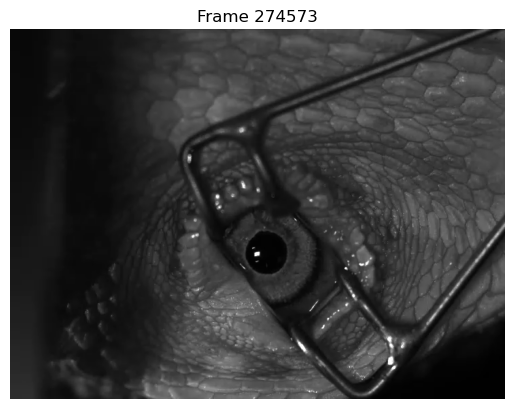

In [45]:
# Your video file path
Video_specific_files = [file for file in all_files if file.endswith('.mp4')
                    and "_"+str(Data['Insertion'][ex])+"_" in file and 'labeled' not in file]


# The index from your DataFrame
frame_index = idx_min  # Replace with your actual index if needed

video_path = os.path.join(directory,Video_specific_files[0])
# Open the video
cap = cv2.VideoCapture(video_path)

# Check if video opened successfully
if not cap.isOpened():
    raise IOError(f"Cannot open video file: {video_path}")

# Set the video to the desired frame
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)

# Read the frame
ret, frame = cap.read()

if ret:
    # frame is a numpy array of shape (height, width, 3) in BGR format
    print(f"Successfully read frame {frame_index}")
else:
    print(f"Failed to read frame {frame_index}")

# Don't forget to release the capture object
cap.release()

frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Plot the frame
plt.imshow(frame_rgb)
plt.title(f"Frame {frame_index}")
plt.axis('off')  # Hide axes for better display
plt.show()

274573

In [19]:
s_file

['PV132_8_Camera1_20250507-214316DLC_Resnet50_IR_Eye_movementsApr29shuffle1_snapshot_200_inverted_Eye_ellipse_thr_0.8.csv']